# Imports

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Load and Read JSON File

In [2]:
with open(r"C:\CV\TSAI_Course\TSAI-EVA5\Week12\Hardhat,boots,vest,mask_coco.json") as f:
    data = json.load(f)

# Structure of the JSON File

The json file contains image file info and annotations in COCO Format. The contents of the Json File is described below in detail.
It has the following sections:
1. **info**: It contains information about the dataset such as year, version, description, contributor, url and date created.
    * year: Year of creation of dataset
    * version: Version of the dataset
    * description: A brief description of the dataset
    * contributor: Person or Organization who created the dataset
    * url: link to the dataset
    * date_created: Date of creation of dataset
2. **licenses**: Legal documents that says how the dataset can be used. It has a list of licenses each containing license id, name and url
    * id: ID of the license type
    * name: Name of the license
    * url: URL of that particular license
3. **images**: It contains information about each image in the dataset. It has the following information:
    * id: Unique ID of the image file
    * width: Width of the image file in pixels
    * height: Height of the image file in pixels
    * file_name: Name of the image file
    * license: License ID of the image
    * date_captured: Timestamp when the image was captured
4. **annotations**: It has the information about the bounding boxes for all the images. It has the following information:
    * id: Unique ID of the bounding box
    * image_id: ID of the image to which the bounding box belongs to
    * category_id: ID of the class to which the bounding box belongs to
    * bbox: It is an array containing x,y,w and h of the bounding box where x,y are the coordinate of the upper left corner of the bounding box and w and h are the width and height of the bounding box
    * area: Area subtended by the bounding box
    * segmentation: List of coordinates of all vertices of the bounding box. For rectangular bounding box, it is represented as the x and y coordinates of 4 vertices.
    * iscrowd: It has True or False (1 or 0 value). It means whether the object is a single instance or a group of instances.
5. **categories**: It contains information about the classes and groups of classes. It has the following content in it:
    * id: Unique ID of the class label
    * supercategory: larger grouping of the class. For eg - A bicycle class can have a supercategory of vehicle.
    * name: Class label or name of the class

# Reading the sections into DataFrames

In [3]:
image_df = DataFrame(data['images'])
image_df

,id,width,height,file_name,license,date_captured
0,1,3497,2564,1.jpeg,0,
1,2,620,300,2.jpeg,0,
2,3,1026,1390,3.jpeg,0,
3,4,356,470,4.jpeg,0,
4,5,1139,1600,5.jpeg,0,
...,...,...,...,...,...,...
66,67,3475,2312,bootsA_1.jpeg,0,
67,68,275,183,bootsA_2.jpeg,0,
68,69,183,275,bootsA_3.jpeg,0,
69,70,300,168,bootsA_4.jpeg,0,


In [4]:
annotations_df = DataFrame(data['annotations'])
annotations_df

,segmentation,area,bbox,iscrowd,id,image_id,category_id
0,"[[1426, 336, 2327, 336, 2327, 905, 1426, 905]]",512669,"[1426, 336, 901, 569]",0,1,1,1
1,"[[56, 9, 94, 9, 94, 35, 56, 35]]",988,"[56, 9, 38, 26]",0,2,2,1
2,"[[158, 27, 198, 27, 198, 57, 158, 57]]",1200,"[158, 27, 40, 30]",0,3,2,1
3,"[[224, 29, 261, 29, 261, 60, 224, 60]]",1147,"[224, 29, 37, 31]",0,4,2,1
4,"[[352, 23, 396, 23, 396, 57, 352, 57]]",1496,"[352, 23, 44, 34]",0,5,2,1
...,...,...,...,...,...,...,...
302,"[[1567, 116, 1947, 116, 1947, 443, 1567, 443]]",124260,"[1567, 116, 380, 327]",0,303,71,4
303,"[[73, 571, 410, 571, 410, 931, 73, 931]]",121320,"[73, 571, 337, 360]",0,304,71,4
304,"[[548, 628, 936, 628, 936, 925, 548, 925]]",115236,"[548, 628, 388, 297]",0,305,71,4
305,"[[1082, 568, 1432, 568, 1432, 931, 1082, 931]]",127050,"[1082, 568, 350, 363]",0,306,71,4


In [5]:
categories_df = DataFrame(data['categories'])
categories_df

,supercategory,id,name
0,class_name,1,hardhat
1,class_name,2,mask
2,class_name,3,vest
3,class_name,4,boots


In [6]:
anchor_boxes_df = annotations_df.copy()

In [7]:
bbox_df = DataFrame(item for item in anchor_boxes_df['bbox'])
bbox_df.columns = ['CX', 'CY', 'W', 'H']
bbox_df

,CX,CY,W,H
0,1426,336,901,569
1,56,9,38,26
2,158,27,40,30
3,224,29,37,31
4,352,23,44,34
...,...,...,...,...
302,1567,116,380,327
303,73,571,337,360
304,548,628,388,297
305,1082,568,350,363


In [8]:
anchor_boxes_df = pd.concat([anchor_boxes_df, bbox_df], axis=1)
anchor_boxes_df

,segmentation,area,bbox,iscrowd,id,image_id,category_id,CX,CY,W,H
0,"[[1426, 336, 2327, 336, 2327, 905, 1426, 905]]",512669,"[1426, 336, 901, 569]",0,1,1,1,1426,336,901,569
1,"[[56, 9, 94, 9, 94, 35, 56, 35]]",988,"[56, 9, 38, 26]",0,2,2,1,56,9,38,26
2,"[[158, 27, 198, 27, 198, 57, 158, 57]]",1200,"[158, 27, 40, 30]",0,3,2,1,158,27,40,30
3,"[[224, 29, 261, 29, 261, 60, 224, 60]]",1147,"[224, 29, 37, 31]",0,4,2,1,224,29,37,31
4,"[[352, 23, 396, 23, 396, 57, 352, 57]]",1496,"[352, 23, 44, 34]",0,5,2,1,352,23,44,34
...,...,...,...,...,...,...,...,...,...,...,...
302,"[[1567, 116, 1947, 116, 1947, 443, 1567, 443]]",124260,"[1567, 116, 380, 327]",0,303,71,4,1567,116,380,327
303,"[[73, 571, 410, 571, 410, 931, 73, 931]]",121320,"[73, 571, 337, 360]",0,304,71,4,73,571,337,360
304,"[[548, 628, 936, 628, 936, 925, 548, 925]]",115236,"[548, 628, 388, 297]",0,305,71,4,548,628,388,297
305,"[[1082, 568, 1432, 568, 1432, 931, 1082, 931]]",127050,"[1082, 568, 350, 363]",0,306,71,4,1082,568,350,363


### Merging the image and category into annotation dataframe

In [9]:
anchor_boxes_df['image_width'] = pd.merge(anchor_boxes_df, image_df, left_on='image_id', right_on='id', how='left')['width']
anchor_boxes_df['image_height'] = pd.merge(anchor_boxes_df, image_df, left_on='image_id', right_on='id', how='left')['height']
anchor_boxes_df['class_label'] = pd.merge(anchor_boxes_df, categories_df, left_on='category_id', right_on='id', how='left')['name']
anchor_boxes_df

,segmentation,area,bbox,iscrowd,id,image_id,category_id,CX,CY,W,H,image_width,image_height,class_label
0,"[[1426, 336, 2327, 336, 2327, 905, 1426, 905]]",512669,"[1426, 336, 901, 569]",0,1,1,1,1426,336,901,569,3497,2564,hardhat
1,"[[56, 9, 94, 9, 94, 35, 56, 35]]",988,"[56, 9, 38, 26]",0,2,2,1,56,9,38,26,620,300,hardhat
2,"[[158, 27, 198, 27, 198, 57, 158, 57]]",1200,"[158, 27, 40, 30]",0,3,2,1,158,27,40,30,620,300,hardhat
3,"[[224, 29, 261, 29, 261, 60, 224, 60]]",1147,"[224, 29, 37, 31]",0,4,2,1,224,29,37,31,620,300,hardhat
4,"[[352, 23, 396, 23, 396, 57, 352, 57]]",1496,"[352, 23, 44, 34]",0,5,2,1,352,23,44,34,620,300,hardhat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,"[[1567, 116, 1947, 116, 1947, 443, 1567, 443]]",124260,"[1567, 116, 380, 327]",0,303,71,4,1567,116,380,327,2000,1000,boots
303,"[[73, 571, 410, 571, 410, 931, 73, 931]]",121320,"[73, 571, 337, 360]",0,304,71,4,73,571,337,360,2000,1000,boots
304,"[[548, 628, 936, 628, 936, 925, 548, 925]]",115236,"[548, 628, 388, 297]",0,305,71,4,548,628,388,297,2000,1000,boots
305,"[[1082, 568, 1432, 568, 1432, 931, 1082, 931]]",127050,"[1082, 568, 350, 363]",0,306,71,4,1082,568,350,363,2000,1000,boots


Normalising the bounding box values by image dimensions

In [10]:
anchor_boxes_df['cx'] = anchor_boxes_df['CX']/anchor_boxes_df['image_width']
anchor_boxes_df['cy'] = anchor_boxes_df['CY']/anchor_boxes_df['image_height']
anchor_boxes_df['w'] = anchor_boxes_df['W']/anchor_boxes_df['image_width']
anchor_boxes_df['h'] = anchor_boxes_df['H']/anchor_boxes_df['image_height']

In [11]:
anchor_boxes_df.head()

,segmentation,area,bbox,iscrowd,id,image_id,category_id,CX,CY,W,H,image_width,image_height,class_label,cx,cy,w,h
0,"[[1426, 336, 2327, 336, 2327, 905, 1426, 905]]",512669,"[1426, 336, 901, 569]",0,1,1,1,1426,336,901,569,3497,2564,hardhat,0.407778,0.131045,0.257649,0.221919
1,"[[56, 9, 94, 9, 94, 35, 56, 35]]",988,"[56, 9, 38, 26]",0,2,2,1,56,9,38,26,620,300,hardhat,0.090323,0.030000,0.061290,0.086667
2,"[[158, 27, 198, 27, 198, 57, 158, 57]]",1200,"[158, 27, 40, 30]",0,3,2,1,158,27,40,30,620,300,hardhat,0.254839,0.090000,0.064516,0.100000
3,"[[224, 29, 261, 29, 261, 60, 224, 60]]",1147,"[224, 29, 37, 31]",0,4,2,1,224,29,37,31,620,300,hardhat,0.361290,0.096667,0.059677,0.103333
4,"[[352, 23, 396, 23, 396, 57, 352, 57]]",1496,"[352, 23, 44, 34]",0,5,2,1,352,23,44,34,620,300,hardhat,0.567742,0.076667,0.070968,0.113333


# Plot for h vs w and log(h) vs log(w)

[Text(0, 0.5, 'log(h)'),
 Text(0.5, 0, 'log(w)'),
 Text(0.5, 1.0, 'Plot of log(h) vs log(w)')]

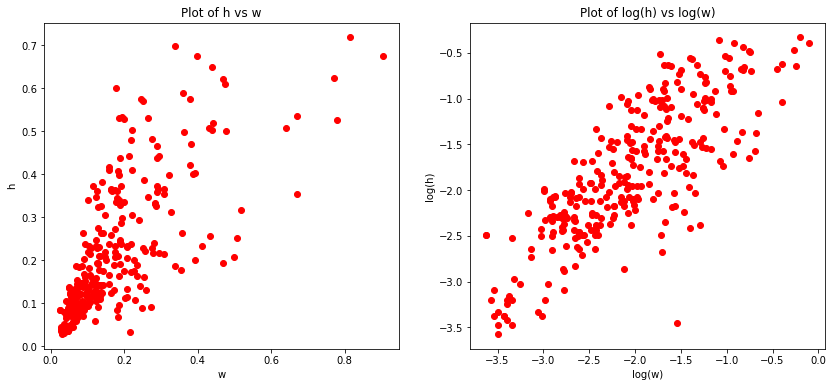

In [17]:
fig,ax = plt.subplots(1, 2, figsize = (14, 6))
axis = ax.flatten()
axis[0].scatter(anchor_boxes_df['w'], anchor_boxes_df['h'], color='red')
axis[0].set(xlabel = 'w', ylabel='h', title = 'Plot of h vs w')
axis[1].scatter(np.log(anchor_boxes_df['w']), np.log(anchor_boxes_df['h']), color='red')
axis[1].set(xlabel = 'log(w)', ylabel='log(h)', title = 'Plot of log(h) vs log(w)')

In [13]:
anchor_boxes_df.class_label.value_counts()

boots      96
mask       76
hardhat    75
vest       60
Name: class_label, dtype: int64

# KMeans clustering to find the number of anchor boxes

In [25]:
X = anchor_boxes_df[['w', 'h']].applymap(lambda x:np.log(x))

In [29]:
wcss = []
for i in range(1, 11):
    model = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    model.fit(X)
    #appending the WCSS to the list (kmeans.inertia_ returns the WCSS value for an initialized cluster)
    wcss.append(model.inertia_)  

Text(0.5, 1.0, 'Plot of number of clusters vs WCSS')

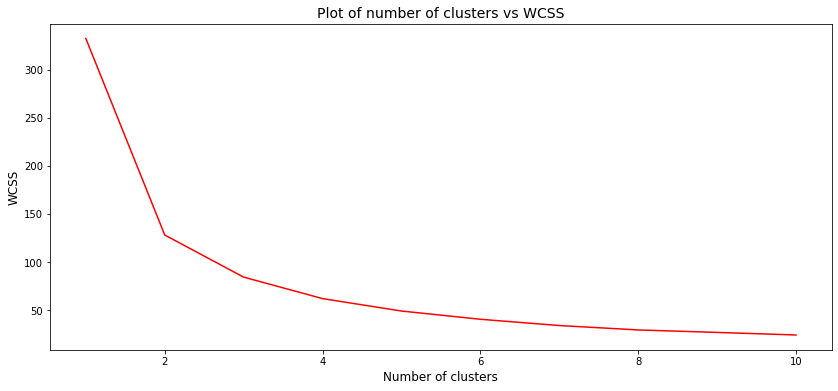

In [31]:
#ELbow Plot for choosing the correct number of clusters
fig,ax = plt.subplots(figsize = (14, 6))
ax.plot(np.arange(1, 11), wcss, color='red')
ax.set_xlabel(xlabel = 'Number of clusters', fontsize=12)
ax.set_ylabel('WCSS', fontsize = 12)
ax.set_title('Plot of number of clusters vs WCSS', fontsize=14)

After K=4, the WCSS stops decreasing. So k=4 is the optimal cluster numbers. 
Now lets looka the the clusters and cluster centres

In [32]:
model = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
model.fit(X)

KMeans(n_clusters=4, random_state=42)

In [35]:
clusters = model.labels_
cluster_centres = model.cluster_centers_

In [53]:
cluster_centres

array([[-1.76108804, -1.49993788],
       [-2.49902409, -2.23281461],
       [-3.27354766, -3.09554396],
       [-1.03664028, -0.83978789]])

Text(0.5, 1.0, 'Plot of cluster points and cluster centres')

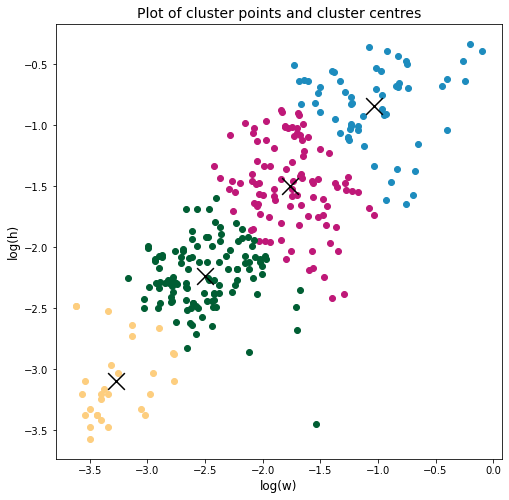

In [71]:
fig,ax = plt.subplots(figsize = (8, 8))
colors = ['#BF1878', '#005E33', '#FDCE7F', '#1D8CBE']
for i in range(cluster_centres.shape[0]):
    cluster_points = X.iloc[np.where(clusters == i)[0], :].values
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i])
    ax.scatter(cluster_centres[i, 0], cluster_centres[i, 1], color='black', marker='x', s=280)

ax.set_xlabel('log(w)', fontsize=12)
ax.set_ylabel('log(h)', fontsize=12)
ax.set_title("Plot of cluster points and cluster centres", fontsize=14)